In [1]:
import random
import numpy as np
import pandas as pd
from collections import deque
# import tensorflow as tf 
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam 

Using TensorFlow backend.


In [0]:
import sys 
sys.path.append("/content/drive/My Drive/Colab Notebooks/")
import roles_simple as rs 

# Load clicking and buying data

In [0]:
# MY_PATH = "drive/My Drive/github/erdos_project/"
# df_all = pd.read_csv(MY_PATH+"clean.csv", index_col=0)

In [0]:
trained_prob = pd.read_csv("/content/drive/My Drive/Colab Notebooks/trained_prob.csv", index_col=0)
trained_prob = trained_prob.to_numpy()

# DQN solver class

In [0]:
GAMMA = .95 
LEARNING_RATE = .001 
MEMORY_SIZE = 1000
BATCH_SIZE = 25 
NUM_EPISODES = 4
NUM_ROUNDS = 200

EXPLORATION_RATE = .15

PENALTY_FOR_TOO_FEW_CUSTOMER = 150

In [0]:
class DQNSolver: 

    def __init__(self, observation_space_size, action_space_size): 
        self.exploration_rate = EXPLORATION_RATE 

        self.action_space_size = action_space_size
        self.observation_space_size = observation_space_size
        self.memory = deque(maxlen=MEMORY_SIZE)

        self.model = Sequential()
        self.model.add(Dense(16, input_shape=(observation_space_size,), activation="relu"))
        self.model.add(Dense(8, activation="relu"))
        self.model.add(Dense(action_space_size, activation="linear"))
        self.model.compile(loss='mse', optimizer=Adam())

    def memorize(self, state, action, reward, next_state, terminal): 
        self.memory.append((state, action, reward, next_state, terminal))

    def act(self, state): 
        """ Returns action index 
        """
        if np.random.rand() < self.exploration_rate: 
            return random.randrange(self.action_space_size)
        # q_values = self.model.predict( np.array([state,]) )
        q_values = self.model.predict(state.reshape(1,-1))
        return np.argmax(q_values[0])

    def experience_replay(self): 
        if len(self.memory) < BATCH_SIZE: 
            return 
        batch = random.sample(self.memory, BATCH_SIZE)

        for state, action, reward, next_state, terminal in batch: 
            q_update = reward 
            if not terminal: 
                q_update = reward + GAMMA * \
                           np.amax(self.model.predict(next_state.reshape(1,-1))[0])
            q_values = self.model.predict(state.reshape(1,-1))
            q_values[0][action] = q_update 
            self.model.fit(state.reshape(1,-1), q_values, verbose=False)
            # print('Done with update!')


## Test ```DQNSolver```

In [0]:
dqn_test = DQNSolver(4,8)

In [0]:
state = np.array([.5,.3,.2,11])
dqn_test.model.predict(np.array( [state,] ))[0]

array([ 0.43996722, -0.36895674, -3.637159  , -0.5471861 , -0.68206674,
       -0.3897757 , -1.3910795 ,  1.882704  ], dtype=float32)

In [0]:
np.array([state,]).shape

(1, 4)

In [0]:
print(dqn_test.model.predict(np.array( [state,] )))
# dqn_test.model.predict(state.reshape(1,-1))[0]

[[ 0.43996722 -0.36895674 -3.637159   -0.5471861  -0.68206674 -0.3897757
  -1.3910795   1.882704  ]]


In [0]:
dqn_test.act(state)

2

# InsuranceCompany class

In [0]:
class InsuranceCompany: 

    def __init__(self, prob_bid_g10, span=2): 
        self.distribution = prob_bid_g10
        self.span = span 
    
    # def set_param(self, **kwargs):
    #     # Use this function to set parameters like married, num_of_vehicles etc 
    #     for k,v in kwargs.items(): 
    #         self.param_[k] = v 

    # def get_param(self): 
    #     return self.param_

    def bid(self, customer_type): 
        p = self.distribution[customer_type]
        bid_mean = 10 + (2*p-1)*self.span 
        bid_span = self.span 
        return (2*bid_span)*np.random.rand() + bid_mean - bid_span


In [0]:
# Testing InsuranceCompany class
test_company = InsuranceCompany(trained_prob[:,0])
test_company.bid(11)

7.709586965309143

# Simulation

## Set up data and functions

In [0]:
GAMMA = .95 
LEARNING_RATE = .1 
MEMORY_SIZE = 10000
BATCH_SIZE = 50 
NUM_EPISODES = 5
NUM_ROUNDS = 1000

EXPLORATION_RATE = .1

# PENALTY_FOR_TOO_FEW_CUSTOMER = 150

In [0]:
def normalize_random(num_rows, num_cols):
    ans = np.random.rand(num_rows, num_cols)
    ans = ans/ans.sum(axis=1)[:,None]
    return ans

In [0]:
p_click = np.array([[0.5714285714285714,0.2,0.1,0.0,0.018247407217204643],
[0.5095541401273885,0.2153846153846154,0.14767932489451477,0.03821656050955414,0.018247407217204643],
[0.5141843971631206,0.20689655172413793,0.19469026548672566,0.04833952594122306,0.018247407217204643],
[0.4887459807073955,0.16149068322981366,0.08759124087591241,0.04833952594122306,0.018247407217204643],
[0.5407706854520101,0.19234842124517404,0.047619047619047616,0.12121212121212122,0.017543859649122806],
[0.5407706854520101,0.19234842124517404,0.16756756756756758,0.031545741324921134,0.024777006937561942],
[0.5407706854520101,0.17525773195876287,0.125,0.031007751937984496,0.01020408163265306],
[0.5407706854520101,0.1935483870967742,0.12307692307692308,0.03937007874015748,0.022988505747126436],
[0.6363636363636364,0.25,0.0,0.07142857142857142,0.018247407217204643],
[0.5,0.13725490196078433,0.14732142857142858,0.05921052631578947,0.018247407217204643],
[0.5233644859813084,0.18994413407821228,0.1366120218579235,0.05084745762711865,0.018247407217204643],
[0.5825242718446602,0.2085889570552147,0.18556701030927836,0.03731343283582089,0.018247407217204643],
[0.5407706854520101,0.19234842124517404,0.29411764705882354,0.08,0.0],
[0.5407706854520101,0.19234842124517404,0.16296296296296298,0.046052631578947366,0.016299137104506232],
[0.5407706854520101,0.13793103448275862,0.14393939393939395,0.03676470588235294,0.020833333333333332],
[0.5407706854520101,0.2318840579710145,0.16793893129770993,0.033783783783783786,0.03333333333333333]])

In [0]:
p_sale = np.array([[0.2857142857142857,0.2,0.0,0.0,0.005353523911122019],
[0.28662420382165604,0.11794871794871795,0.06329113924050633,0.03184713375796178,0.005353523911122019],
[0.2695035460992908,0.10919540229885058,0.08849557522123894,0.017758623184861884,0.005353523911122019],
[0.22508038585209003,0.07453416149068323,0.014598540145985401,0.017758623184861884,0.005353523911122019],
[0.2408855385520363,0.09114892549015914,0.047619047619047616,0.030303030303030304,0.0],
[0.2408855385520363,0.09114892549015914,0.08108108108108109,0.012618296529968454,0.01288404360753221],
[0.2408855385520363,0.07216494845360824,0.0375,0.015503875968992248,0.01020408163265306],
[0.2408855385520363,0.07526881720430108,0.038461538461538464,0.0,0.0],
[0.36363636363636365,0.25,0.0,0.07142857142857142,0.005353523911122019],
[0.22077922077922077,0.04411764705882353,0.07589285714285714,0.02631578947368421,0.005353523911122019],
[0.14953271028037382,0.05027932960893855,0.0273224043715847,0.00847457627118644,0.005353523911122019],
[0.1262135922330097,0.03680981595092025,0.04639175257731959,0.007462686567164179,0.005353523911122019],
[0.2408855385520363,0.09114892549015914,0.11764705882352941,0.0,0.0],
[0.2408855385520363,0.09114892549015914,0.03209876543209877,0.01644736842105263,0.00862895493767977],
[0.2408855385520363,0.034482758620689655,0.030303030303030304,0.014705882352941176,0.0],
[0.2408855385520363,0.028985507246376812,0.030534351145038167,0.013513513513513514,0.011111111111111112]])

In [0]:
def to_bin(customer_type): 
    return np.array([0]*(customer_type) + [1] + [0]*(15-customer_type))

In [0]:
# Initialize observation_space 
#   = [percent_played, percent_clicked, percent_bought, customer_type]
observation_space = np.concatenate([np.array([0.0,0.0,0.0]), to_bin(0)])

# Initialize action_space 
action_space = np.linspace(6,13,8)

# sample_state_2 = np.array([0.5, 0.2, 0.03, 2]) # not_ins, 1v, 2d, no_m
# sample_state_13 = np.array([0.5, 0.2, 0.03, 13]) # ins, 2v, 1d, m



In [0]:
def create_objects(): 
    # Initialize competitors and website 
    NUM_TYPE_CUSTOMERS = 16
    NUM_COMPETITORS = 4
    competitors_list = [None]*NUM_COMPETITORS

    for i in range(NUM_COMPETITORS):
        competitor = InsuranceCompany(trained_prob[:,i])
        competitors_list[i] = competitor
    
    # Initialize website 
    website = rs.SearchWebsite(p_click, p_sale)
    
    # Initialize DQN solver 
    dqn = DQNSolver(observation_space.size, action_space.size)
    return (website, dqn, competitors_list)


In [0]:
def train(website, dqn, competitors_list, NUM_EPISODES, NUM_ROUNDS, already_trained): 

    ###### Start training ######
    for ep in range(NUM_EPISODES): 
        print('Starting epsisode', ep+already_trained)
        customer = website.generateRandomCustomer()
        num_clicked = 0 
        num_sold = 0 
        total_cost = 0 
        old_state = np.concatenate([np.array([0.0,0.0,0.0]), to_bin(customer)])

        for r in range(1,NUM_ROUNDS+1): 
            if r%20==1:
                print(' Starting round {}/{}'.format(r, NUM_ROUNDS))
                if num_sold != 0:
                    print('     Cost per customer = {}'.format(total_cost/num_sold))
                    print('     Percent click = {}'.format(num_clicked/r))
                    print('     Percent sale = {}'.format(num_sold/r))

            # Bid 
            action_index = dqn.act(np.concatenate([np.array([r/NUM_ROUNDS, num_clicked/r, 
                                  num_sold/r]), to_bin(customer)]))
            my_bid = action_space[action_index]
            bids = [c.bid(customer) for c in competitors_list]


            # Compute reward 
            rank = website.rankBid(bids)
            is_clicked, is_sold = website.rewardDecision(customer, rank)
            
            total_cost += my_bid * is_clicked 

            if num_clicked == 0: 
                reward = 0
            else:
                if num_sold == 0: 
                    reward = -20.0
                else:
                    reward = -total_cost/num_clicked + is_sold*200
            # -my_bid*is_clicked + 40*is_sold
                    #  (num_sold/r - 0.04)*50 + \
            terminal = (r>1 and r%100==1)
            if terminal:  
                reward += (num_sold/NUM_ROUNDS-0.04) * 5000
                
            
            
            # Get new state
            customer = website.generateRandomCustomer()
            num_clicked += is_clicked 
            num_sold += is_sold 
            new_state = np.concatenate([np.array([r/NUM_ROUNDS, num_clicked/r, 
                                  num_sold/r]), to_bin(customer)])
            
            # Memorize 
            dqn.memorize(old_state, action_index, reward, 
                         new_state, terminal)
            old_state = new_state
            
            dqn.experience_replay()

            
        # record prediction history 
        # prediction_history_2.append(dqn.model.predict(sample_state_2.reshape(1,-1))[0])
        # prediction_history_13.append(dqn.model.predict(sample_state_13.reshape(1,-1))[0])
        print("END episode. percent_clicked = {}, percent_sold = {}"\
              .format(num_clicked/NUM_ROUNDS, num_sold/NUM_ROUNDS))

    return dqn 



## Start training

In [0]:
website, dqn, competitors_list = create_objects()

In [0]:
dqn.exploration_rate = .25
train(website, dqn, competitors_list, 1, 1000, 0)

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
def minus_row_mean(matrix): 
    matrix = np.array(matrix)
    return matrix - matrix.mean(axis=1).reshape(-1,1)

In [0]:
m = np.array([[1,3],
              [0,4]])
print(minus_row_mean(m))

[[-1.  1.]
 [-2.  2.]]


In [0]:
ans = np.zeros((16,action_space.size))
for i in range(16):
    state = np.concatenate([np.array([.5, .5, .04]), to_bin(i)])
    ans[i] = dqn.model.predict(state.reshape(1,-1))[0]

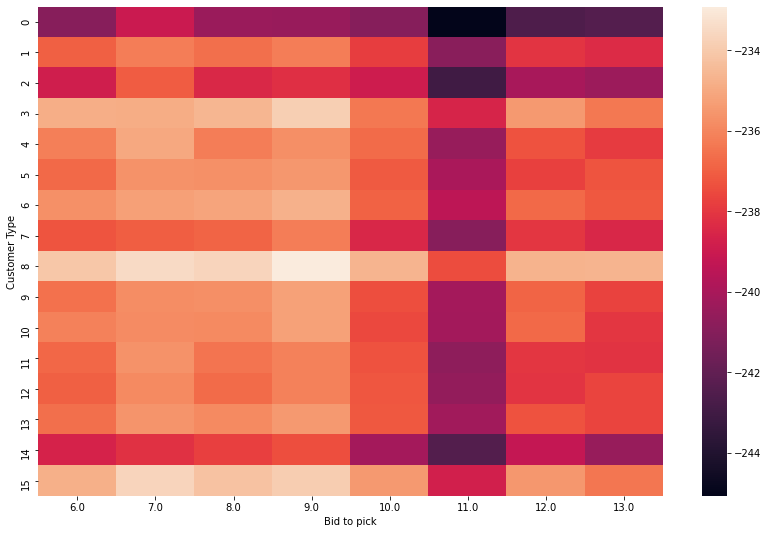

In [49]:
f = plt.figure(figsize=(14,9))
sns.heatmap(ans, xticklabels=action_space, yticklabels=range(16))
plt.xlabel('Bid to pick')
plt.ylabel('Customer Type')
plt.show()